In [157]:
%matplotlib inline
import numpy as np
import nltk
import glob
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import sklearn.decomposition
from collections import defaultdict

In [ ]:
#Load Shakespeare scenes
f = open('shakespeare_scenes.txt')
shk = f.read()
shakespeare_scenes = eval(shk)
f.close()

#Load Shakespeare acts
f = open('shakespeare_acts.txt')
shk = f.read()
shakespeare_acts = eval(shk)
f.close()

In [105]:
#Create baseline of all text in all plays
all_acts_text = []
all_acts_lines = []
for act in shakespeare_acts:
    all_acts_text.append(act['text'])
all_text = ' '.join(all_acts_text).lower()
all_lines = ' '.join(all_acts_lines)
all_tokens = nltk.word_tokenize(all_text)
all_freq = nltk.FreqDist(all_tokens)
#Get top 20 most frequent terms across all plays - remove punctuation we are using for structure vector
vocabulary = [item[0] for item in sorted(all_freq.items(), key=lambda x: x[1], reverse=True) if item[0] not in[";", ",", ":", ".", "?", "!", "'"]][:75]
print (vocabulary)

['the', 'and', 'i', 'to', 'of', 'you', 'a', 'my', 'that', 'in', 'is', 'not', 'me', 'it', 'for', "'s", 'with', 'be', 'your', 'he', 'this', 'his', 'but', 'have', 'as', 'thou', "'d", 'him', 'so', 'will', 'what', 'thy', 'her', 'do', 'no', 'all', 'by', 'we', 'shall', 'if', 'are', 'thee', 'our', 'on', 'good', 'now', 'lord', 'o', 'from', 'come', 'sir', "'ll", 'she', 'at', 'they', 'or', 'was', 'let', 'which', 'here', 'more', 'would', 'there', 'well', 'how', 'then', 'am', '--', 'love', 'when', 'their', 'can', 'man', 'them', 'hath']


In [97]:
def structural(data):
    elements_text = [element['text'] for element in data]
    elements_lines = [element['lines'] for element in data]
    elements_count = len(data)
    
    features = np.zeros((elements_count, 15), np.float64)
    for i, element in enumerate(elements_lines):
        text = ' '.join(element)
        lines = element
        lines_count = len(lines)
        tokens = nltk.word_tokenize(text.lower())
        sentences = nltk.data.load('tokenizers/punkt/english.pickle').tokenize(text.lower())
        sentences_count = len(sentences)
        words = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(text.lower())
        words_unique = list(set(words))        
        words_line_counts = [len(nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(line.lower())) for line in lines]        
        words_sent_counts = [len(nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sentence.lower())) for sentence in sentences]

        #Calculate features
        mean_word_freq = float(len(words))/float(len(words_unique))
        mean_words_line = np.mean(words_line_counts)
        std_words_line = np.std(words_line_counts)
        mean_words_sent = np.mean(words_sent_counts)
        std_words_sent = np.std(words_sent_counts)
        mean_commas_line = float(tokens.count(","))/float(lines_count)
        mean_commas_sent = float(tokens.count(","))/float(sentences_count)
        mean_colons_line = float(tokens.count(":"))/float(lines_count)
        mean_colons_sent = float(tokens.count(":"))/float(sentences_count)
        mean_scolons_line = float(tokens.count(";"))/float(lines_count)
        mean_scolons_sent = float(tokens.count(";"))/float(sentences_count)
        mean_qmarks_line = float(tokens.count("?"))/float(lines_count)
        mean_qmarks_sent = float(tokens.count("?"))/float(sentences_count)
        mean_exmarks_line = float(tokens.count("!"))/float(lines_count)
        mean_exmarks_sent = float(tokens.count("!"))/float(sentences_count)
        
        #Assign features to matrix
        features[i,0] = mean_word_freq
        features[i,1] = mean_words_line
        features[i,2] = std_words_line
        features[i,3] = mean_words_sent
        features[i,4] = std_words_sent
        features[i,5] = mean_commas_line
        features[i,6] = mean_commas_sent
        features[i,7] = mean_colons_line
        features[i,8] = mean_colons_sent
        features[i,9] = mean_scolons_line
        features[i,10] = mean_scolons_sent
        features[i,11] = mean_qmarks_line
        features[i,12] = mean_qmarks_sent
        features[i,13] = mean_exmarks_line
        features[i,14] = mean_exmarks_sent    
        
    return features

In [106]:
def word_freq(data):
    elements_text = [element['text'].lower() for element in data]
    
    vectorizer = CountVectorizer(vocabulary=vocabulary, tokenizer=nltk.word_tokenize)
    freq_vec = vectorizer.fit_transform(elements_text).toarray().astype(np.float64)
 
    return freq_vec

In [140]:
from nltk.util import ngrams
def ngram_freq(text, n):
    tokens = [item for item in nltk.word_tokenize(text) if item not in [',', '.']]
    ng = ngrams(tokens, n)
    ng_freq = nltk.FreqDist(ng)
    return ng_freq


In [ ]:
ng_all = ngram_freq(all_text,3)
ng_all_freq = [item[0] for item in sorted(ng_all.items(), key=lambda x: x[1], reverse=True)][:50]
#ng_all_freq = [' '.join(item[0]) for item in sorted(ng_all.items(), key=lambda x: x[1], reverse=True)][:50]
print(ng_all_freq)

In [155]:
def ngram_freq_vec(data):
    elements_text = [element['text'].lower() for element in data]
    elements_count = len(elements_text)
    elements_ngram = [[' '.join(item[0]) for item in ngram_freq(element, 3)] for element in elements_text]
    
    ng_freq_vec = np.zeros((elements_count, 50), np.float64)
    for i, element in enumerate(elements_text):
        ngdict = defaultdict(int)
        ngf = ngram_freq(element, 3)
        for item in ngf:
            ngdict[' '.join(item[0])] = item[1]
#        ngf_joined = [' '.join(item[0]) for item in ngf]
        for j, item in enumerate (ng_all_freq):
            ng_freq_vec[i,j] = ngdict[item]
            
        
    #vectorizer = CountVectorizer(vocabulary=ng_all_freq)#, tokenizer=nltk.word_tokenize)
    #ng_freq_vec = vectorizer.fit_transform(elements_ngram).toarray().astype(np.float64)
    return ng_freq_vec

In [160]:
ngram_freq_vec(shakespeare_acts)
km_ng = KMeans(n_clusters=3, init='k-means++', n_init=99)
km_ng.fit(ngram_freq_vec)
km_ng_pred = km_freq.predict(ngram_freq_vec)

km_ng_score = silhouette_score(ngram_freq_vec, km_ng_pred, metric='sqeuclidean')
km_ng_score

TypeError: float() argument must be a string or a number, not 'function'

In [162]:
document = [element['text'].lower() for element in shakespeare_acts]
vectorizer = CountVectorizer(ngram_range=(1, 5))

# Don't need both X and transformer; they should be identical
X = vectorizer.fit_transform(document)
matrix_terms = np.array(vectorizer.get_feature_names())

# Use the axis keyword to sum over rows
matrix_freq = np.asarray(X.sum(axis=0)).ravel()
final_matrix = np.array([matrix_terms,matrix_freq])

terms = vectorizer.get_feature_names()
freqs = X.sum(axis=0).A1
result = dict(zip(terms, freqs))
print (result)

In [113]:
def authorship(data, clusters):
    freq = word_freq(data)
    struc = structural(data)
    km_freq = KMeans(n_clusters=clusters, init='k-means++', n_init=99)
    km_struc = KMeans(n_clusters=clusters, init='k-means++', n_init=99)
    km_freq.fit(freq)
    km_struc.fit(struc)
    km_freq_pred = km_freq.predict(freq)
    km_struc_pred = km_struc.predict(struc)
    km_freq_score = silhouette_score(freq, km_freq_pred, metric='sqeuclidean')
    km_struc_score = silhouette_score(struc, km_struc_pred, metric='sqeuclidean')
    gmm_freq = GMM(n_components = clusters, covariance_type="full")
    gmm_struc = GMM(n_components = clusters, covariance_type="full")
    gmm_freq.fit(freq)
    gmm_struc.fit(struc)
    gmm_freq_pred = gmm_freq.predict(freq)
    gmm_struc_pred = gmm_struc.predict(struc)
    gmm_freq_score = silhouette_score(freq, gmm_freq_pred, metric='sqeuclidean')
    gmm_struc_score = silhouette_score(freq, gmm_struc_pred, metric='sqeuclidean')
    return [km_freq, km_freq_score], [km_struc, km_struc_score], [gmm_freq, gmm_freq_score], [gmm_struc, gmm_struc_score]

In [125]:
km_acts_freq, km_acts_struc, gmm_acts_freq, gmm_acts_struc = authorship(shakespeare_acts, 3)
km_scenes_freq, km_scenes_struc, gmm_scenes_freq, gmm_scenes_struc = authorship(shakespeare_scenes, 3)

print ("Acts Scores:")
print("Frequency: gmm:", gmm_acts_freq[1], "km:", km_acts_freq[1])
print("Structural: gmm:", gmm_acts_struc[1], "km:", km_acts_struc[1])
print ("Scenes Scores:")
print("Frequency: gmm:", gmm_scenes_freq[1], "km:", km_scenes_freq[1])
print("Structural: gmm:", gmm_scenes_struc[1], "km:", km_scenes_struc[1])

Acts Scores:
Frequency: gmm: 0.399469235729 km: 0.421806507705
Structural: gmm: 0.311433911817 km: 0.6567109778
Scenes Scores:
Frequency: gmm: 0.499902335515 km: 0.626385454173
Structural: gmm: -0.365955552204 km: 0.776378749835


C:\Users\greeniend\Anaconda\envs\py3k\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


C:\Users\greeniend\Anaconda\envs\py3k\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


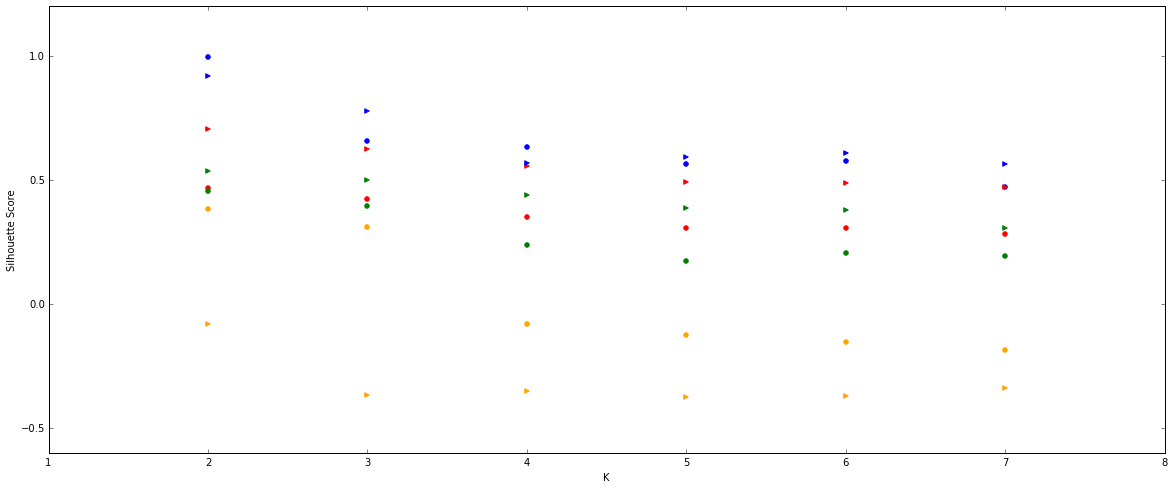

In [117]:
colors = ['red', 'blue', 'green', 'orange']
labels =['km_freq', 'km_struc','gmm_freq', 'gmm_struc']

plt.figure(figsize=(20,8))

for k in range(2,8):
    scores_acts = [item[1] for item in authorship(shakespeare_acts, k)]
    scores_scenes = [item[1] for item in authorship(shakespeare_scenes, k)]
    for i, item in enumerate (scores_acts):
        plt.scatter(k, item, color=colors[i], label=labels[i] + "_acts")
    for i, item in enumerate (scores_scenes):
        plt.scatter(k, item, color=colors[i], marker=">", label=labels[i] + "_scenes")

plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.show()
    
    

In [101]:
columns = ['Title', 'Act', 'Frequency_km', 'Structural_km']
clusters = pd.DataFrame(columns = columns)
clusters['Title'] = [item['title'] for item in shakespeare_acts]
clusters['Act'] = [item['act'] for item in shakespeare_acts]
clusters['Frequency_km'] = km_acts_freq[0].labels_
clusters['Structural_km'] = km_acts_struc[0].labels_
print (clusters)
clusters.to_csv('clusters_acts.csv')

                            Title Act  Frequency_km  Structural_km
0       All's Well That Ends Well   1             1              0
1       All's Well That Ends Well   2             0              2
2       All's Well That Ends Well   3             1              2
3       All's Well That Ends Well   4             0              2
4       All's Well That Ends Well   5             1              2
5                  As You Like It   1             0              2
6                  As You Like It   2             0              0
7                  As You Like It   3             0              2
8                  As You Like It   4             1              2
9                  As You Like It   5             1              0
10           The Comedy of Errors   1             1              0
11           The Comedy of Errors   2             1              2
12           The Comedy of Errors   3             1              2
13           The Comedy of Errors   4             1           

In [102]:
columns = ['Title', 'Act', 'Scene', 'Frequency_km', 'Structural_km']
clusters = pd.DataFrame(columns = columns)
clusters['Title'] = [item['title'] for item in shakespeare_scenes]
clusters['Act'] = [item['act'] for item in shakespeare_scenes]
clusters['Scene'] = [item['scene'] for item in shakespeare_scenes]
clusters['Frequency_km'] = km_scenes_freq[0].labels_
clusters['Structural_km'] = km_scenes_struc[0].labels_
print (clusters)
clusters.to_csv('clusters_scenes.csv')

                         Title Act Scene  Frequency_km  Structural_km
0    All's Well That Ends Well   1     1             2              1
1    All's Well That Ends Well   1     2             0              1
2    All's Well That Ends Well   1     3             2              1
3    All's Well That Ends Well   2     1             2              1
4    All's Well That Ends Well   2     2             0              1
5    All's Well That Ends Well   2     3             1              1
6    All's Well That Ends Well   2     4             0              1
7    All's Well That Ends Well   2     5             0              1
8    All's Well That Ends Well   3     1             0              1
9    All's Well That Ends Well   3     2             2              1
10   All's Well That Ends Well   3     3             0              1
11   All's Well That Ends Well   3     4             0              1
12   All's Well That Ends Well   3     5             0              1
13   All's Well That

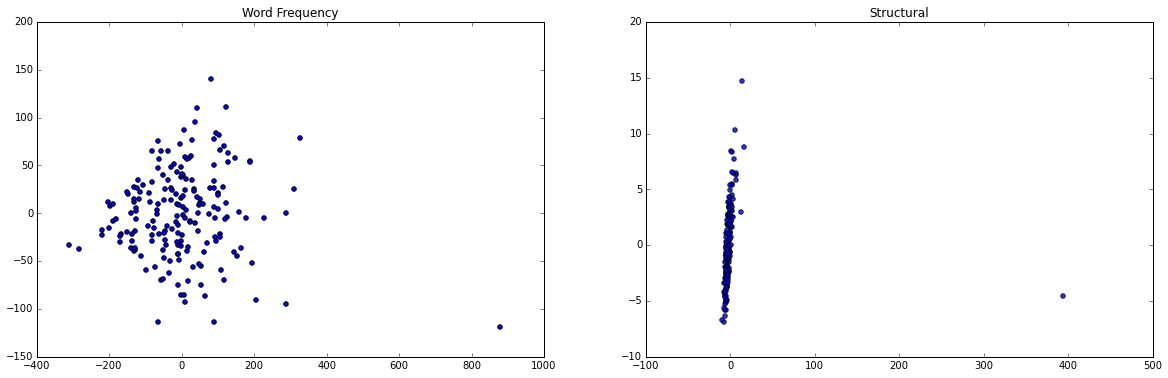

In [103]:
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
freq = word_freq(shakespeare_acts)
centered= freq - np.mean(freq, axis=0)
freq_2d = svd.fit_transform(centered)
struc = structural(shakespeare_acts)
centered2= struc - np.mean(struc, axis=0)
struc_2d = svd.fit_transform(centered2)
#plt.scatter(struc_2d[:,0], struc_2d[:,1])

plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.scatter(freq_2d[:,0], freq_2d[:,1])
plt.title("Word Frequency")

plt.subplot(1, 2, 2)
plt.scatter(struc_2d[:,0], struc_2d[:,1], alpha=0.8)
plt.title("Structural")
plt.show()

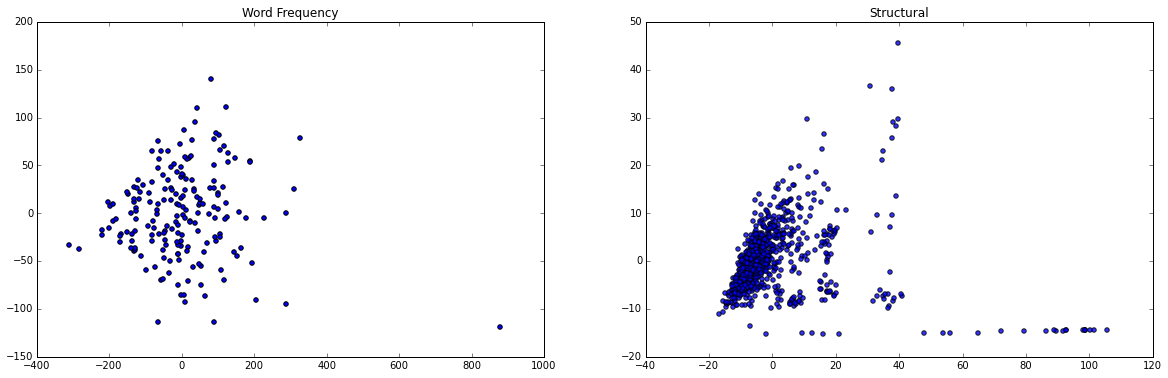

In [104]:
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
freq = word_freq(shakespeare_acts)
centered= freq - np.mean(freq, axis=0)
freq_2d = svd.fit_transform(centered)
struc = structural(shakespeare_scenes)
centered2= struc - np.mean(struc, axis=0)
struc_2d = svd.fit_transform(centered2)
#plt.scatter(struc_2d[:,0], struc_2d[:,1])

plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.scatter(freq_2d[:,0], freq_2d[:,1])
plt.title("Word Frequency")

plt.subplot(1, 2, 2)
plt.scatter(struc_2d[:,0], struc_2d[:,1], alpha=0.8)
plt.title("Structural")
plt.show()